# Peter Kim, OCPython Meetup - August 1, 2017
PeopleSpace, Irvine, CA

## Text Classification with Scikit-Learn

YouTube Spam Collection

The YouTube Spam Collection v. 1 is a public set of YouTube comments that have been collected for spam research. It has five datasets composed by 1,956 real and non-encoded messages that were labeled as legitimate (ham) or spam.
>Alberto, T.C., Lochter J.V., Almeida, T.A. TubeSpam: Comment Spam Filtering on YouTube. Proceedings of the 14th IEEE International Conference on Machine Learning and Applications (ICMLA'15), 1-6, Miami, FL, USA, December, 2015. (preprint).  Available at: http://dcomp.sor.ufscar.br/talmeida/papers/TCA_ICMLA15.pdf
>
> Data Source: http://dcomp.sor.ufscar.br/talmeida/youtubespamcollection/
>
>Also available at UCI Machine Learning Repository.
><br>Source: http://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection#

Download the zip files.  Make sure to include file "Youtube04-Eminem.csv" in same directory.

In [1]:
# Python libraries
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import metrics

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

In [3]:
# Dataframe with Eminem YouTube comments
df_eminem = pd.read_csv("Youtube04-Eminem.csv")

In [4]:
df_eminem.shape

(448, 5)

In [5]:
df_eminem.columns

Index([u'COMMENT_ID', u'AUTHOR', u'DATE', u'CONTENT', u'CLASS'], dtype='object')

# Examine dataframe 
{Class 0: ham, Class 1: spam}
<br>'CONTENT' field is the comment, 'CONTENT' field is the class.
<br>Ignore the other fields.

In [4]:
# Examine dataframe  {Class 0: ham, Class 1: spam}
df_eminem.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z12rwfnyyrbsefonb232i5ehdxzkjzjs2,Lisa Wellas,NaN,+447935454150 lovely girl talk to me xxx﻿,1
1,z130wpnwwnyuetxcn23xf5k5ynmkdpjrj04,jason graham,2015-05-29T02:26:10.652000,I always end up coming back to this song<br />﻿,0
2,z13vsfqirtavjvu0t22ezrgzyorwxhpf3,Ajkal Khan,NaN,"my sister just received over 6,500 new <a rel=...",1
3,z12wjzc4eprnvja4304cgbbizuved35wxcs,Dakota Taylor,2015-05-29T02:13:07.810000,Cool﻿,0
4,z13xjfr42z3uxdz2223gx5rrzs3dt5hna,Jihad Naser,NaN,Hello I&#39;am from Palastine﻿,1


In [63]:
df_eminem['CLASS'].value_counts()

1    245
0    203
Name: CLASS, dtype: int64

In [61]:
# df_eminem['CLASS'].value_counts()
# df_eminem['CLASS'].value_counts().rename(index={1: 'Spam', 0: 'Ham'})
vc_class = df_eminem['CLASS'].value_counts()
vc_class = vc_class.rename(index={1: 'Spam', 0: 'Ham'})
vc_class = vc_class.sort_index()
vc_class

Ham     203
Spam    245
Name: CLASS, dtype: int64

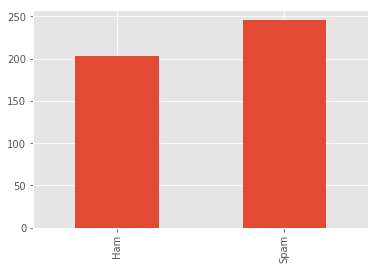

In [62]:
# hist(bins=bins, grid=False); plt.xticks([0,1])
vc_class.plot(kind='bar')

In [64]:
# Split the Content and Classes into train and test sets (20%)
X_train, X_test, y_train, y_test = train_test_split(df_eminem['CONTENT'], df_eminem['CLASS'], 
                                                    random_state=1, test_size=0.2, stratify=df_eminem['CLASS'])

In [65]:
print 'X training size: ', X_train.shape
print 'y training size: ', y_train.shape
print 'X test size: ', X_test.shape
print 'y test size: ', y_test.shape

X training size:  (358L,)
y training size:  (358L,)
X test size:  (90L,)
y test size:  (90L,)


# Vectorize Text into DTM (with Pre-Processing)
* Pre-processing function
* List comprehension with pre-processing function
* LemmaTokenizer class
* CountVectorizer object with LemmaTokenizer

# Surprise: performs worse with pre-processing

In [7]:
# # Pre-processing from Kaggle tutorial

# stop_nltk = stopwords.words("english")
# stop_nltk_plus = stop_nltk + [u'a',u'b',u'c',u'd',u'e',u'f',u'g',u'h',u'i',u'j',
#                          u'k',u'l',u'm',u'n',u'o',u'p',u'q',u'r',u's',u't',
#                          u'u',u'v',u'w',u'x',u'y',u'z']
# # 4. In Python, searching a set is much faster than searching
# #     a list, so convert the stop words to a set
# stops = set(stop_nltk_plus)
    
# # function to process 10k documents
# def process_10kchars(input_text):
#     # 1. Remove non-letters, and make lowercase
#     letters_only = re.sub("[^a-zA-Z]", " ", input_text)
        
#     # 3. Convert to lower case, split into individual words
#     words = letters_only.lower().split()    
    
#     # 5. Remove stop words
#     meaningful_words = [w for w in words if not w in stops]   
    
#     # 6. Join the words back into one string separated by space, 
#     # and return the result.
#     return( " ".join( meaningful_words ))   

In [8]:
# %%time
# # Wall time: 22.1 s

# # list comprehension on X_train_chunks, with process_10kchars
# X_train_process = [process_10kchars(text_file) for text_file in X_train]

# X_test_process = [process_10kchars(text_file) for text_file in X_test]

In [9]:
# # create a new CountVectorizer with lemmatizer
# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = WordNetLemmatizer()
#     def __call__(self, doc):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
# count_vect_lemma = CountVectorizer(tokenizer=LemmaTokenizer())  

In [10]:
# # instantiate CountVectorizer object, with LemmaTokenizer()
# count_vect_lemma = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1, 2), max_features=1000, 
#                                    max_df=0.90, stop_words='english') 

# # Fit the vectorizer object to the X_train text
# X_train_vect = count_vect_lemma.fit(X_train_process, y_train)

# # Transform the training text into a document-term-matrix
# X_train_dtm = X_train_vect.transform(X_train_process)

# print "Size of training dtm: ", X_train_dtm.shape

# # Transform the test text into a document-term-matrix (input fed into models)
# X_test_dtm = X_train_vect.transform(X_test_process)

# print "Size of test dtm: ", X_test_dtm.shape

# Vectorize text into DTM (no pre-processing)
* Leave text unprocessed, no lemmatization

In [66]:
# Instantiate a vectorizer for document-term-matrix
vect = CountVectorizer(max_features=1000)

# Fit the vectorizer object to the X_train text
X_train_vect = vect.fit(X_train, y_train)

# Transform the training text into a document-term-matrix
X_train_dtm = X_train_vect.transform(X_train)

print "Size of training dtm: ", X_train_dtm.shape

Size of training dtm:  (358, 1000)


In [67]:
# Transform the test text into a document-term-matrix (input fed into models)
X_test_dtm = X_train_vect.transform(X_test)

print "Size of test dtm: ", X_test_dtm.shape

Size of test dtm:  (90, 1000)


## Text Classification Example Without GridSearchCV
* In practice, the GridSearchCV class accomplishes same result, while tuning combinations of model parameters.
* But to make it simpler to follow the workflow, here is an example of text classification step-by-step.

In [ ]:
# Step 1: Instatiate a classifier object.
rf_clf = RandomForestClassifier()

# Step 2: "Fit" training data onto model, both data and labels.
# The machine is "learning" how the training words match the label data (or "classes").  
rf_clf.fit(X_train_dtm, y_train)

# Step 3: Predict test data using model, only data (not labels)
# Store results as predictions on test data ... next we will compare with real labels.  
rf_test_predictions = rf_clf.predict(X_test_dtm)

In [ ]:
print("Random Forest Classifier: ")

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, rf_test_predictions))

# print the confusion matrix
print("\nConfusion Matrix: ")
print("(rows are actual, columns are predictions)")
print(metrics.confusion_matrix(y_test, rf_test_predictions, labels=["Ham", "Spam"]))

# print the Classification Report
print("\nClassification Report: ")
print(metrics.classification_report(y_test, rf_test_predictions,target_names=["Ham", "Spam"]))

# Classification Technique #1: Random Forest Classifier

In [68]:
%%time

# Use GridSearchCV to tune model parameters

# parameters 
parameters_rf = {'n_estimators': (10, 50, 100),                 # default 10
                 'bootstrap': (True, False),                          # default true
                  'class_weight': ('balanced', None)}                # default None

# instantiate a classifier object
rf = RandomForestClassifier(random_state=42)

# instantiate a GridSearchCV object
gs_rf = GridSearchCV(rf, parameters_rf, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_rf = gs_rf.fit(X_train_dtm, y_train)

print(gs_rf.best_score_)

for param_name in sorted(parameters_rf.keys()):
    print("%s: %r" % (param_name, gs_rf.best_params_[param_name]))

0.95251396648
bootstrap: False
class_weight: 'balanced'
n_estimators: 50
Wall time: 8.88 s


In [69]:
print "Random Forest Classifier: "

# predict classification
gs_rf_test_predictions = gs_rf.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_rf_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_rf_test_predictions))

print(metrics.classification_report(y_test, gs_rf_test_predictions,target_names=["Ham", "Spam"]))

Random Forest Classifier: 
0.955555555556
[[40  1]
 [ 3 46]]
             precision    recall  f1-score   support

        Ham       0.93      0.98      0.95        41
       Spam       0.98      0.94      0.96        49

avg / total       0.96      0.96      0.96        90



In [70]:
# Verify classes against the y_test data
print "Compare Target Class Label Counts to Classification Report"
print "0: Ham, 1: Spam\n"
print y_test.value_counts(ascending=True)

Compare Target Class Label Counts to Classification Report
0: Ham, 1: Spam

0    41
1    49
Name: CLASS, dtype: int64


# Classification Technique #2: Multinomial Naive Bayes

In [71]:
# Use GridSearchCV to tune model parameters

# parameters for MultinomialNB
parameters_mnb = {'alpha': (0.001, 0.01, 0.1, 1.0, 10.0, 100.0),
                 'fit_prior': (True, False)}    # default is True, use uniform if False

# instantiate a MultinomialNB object
mnb = MultinomialNB()

# instantiate a GridSearchCV object
gs_mnb = GridSearchCV(mnb, parameters_mnb, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_mnb = gs_mnb.fit(X_train_dtm, y_train)

print "Grid Search for MultinomialNB"
print "Accuracy: ", gs_mnb.best_score_
print "alpha: ", gs_mnb.best_params_['alpha']
print "fit_prior: ", gs_mnb.best_params_['fit_prior']
# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

Grid Search for MultinomialNB
Accuracy:  0.916201117318
alpha:  0.1
fit_prior:  False


In [72]:
print "Multinomial Naive Bayes: "

# predict classification
gs_mnb_test_predictions = gs_mnb.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_mnb_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_mnb_test_predictions))

# calculate predicted probabilities (poorly calibrated)
gs_y_pred_test = gs_mnb.predict_proba(X_test_dtm)[:, 1]

# print AUC
print(metrics.roc_auc_score(y_test, gs_y_pred_test))

# print classification report
print(metrics.classification_report(y_test, gs_mnb_test_predictions,target_names=["Ham", "Spam"]))

Multinomial Naive Bayes: 
0.933333333333
[[37  4]
 [ 2 47]]
0.973618715779
             precision    recall  f1-score   support

        Ham       0.95      0.90      0.92        41
       Spam       0.92      0.96      0.94        49

avg / total       0.93      0.93      0.93        90



In [73]:
# Verify classes against the y_test data
print "Compare Target Class Label Counts to Classification Report"
print "0: Ham, 1: Spam\n"
print y_test.value_counts(ascending=True)

Compare Target Class Label Counts to Classification Report
0: Ham, 1: Spam

0    41
1    49
Name: CLASS, dtype: int64


# Classification Technique #3: Support Vector Machines

In [74]:
%%time

# Use GridSearchCV to tune model parameters

# parameters for SVM
parameters_svm = {'penalty': (None, 'l1', 'l2', 'elasticnet'),  # default is 'l2'
                  'alpha': (0.0001, 0.01, 1.0),                 # default 0.0001
                  'class_weight': ('balanced', None)}           # default None

# instantiate a SVM object
svm = SGDClassifier(loss='hinge', random_state=42)

# instantiate a GridSearchCV object
gs_svm = GridSearchCV(svm, parameters_svm, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_svm = gs_svm.fit(X_train_dtm, y_train)

print gs_svm.best_score_

for param_name in sorted(parameters_svm.keys()):
    print "%s: %r" % (param_name, gs_svm.best_params_[param_name])

0.949720670391
alpha: 0.01
class_weight: 'balanced'
penalty: 'elasticnet'
Wall time: 3.63 s


In [75]:
print "Support Vector Machines: "

# predict classification
gs_svm_test_predictions = gs_svm.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_svm_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_svm_test_predictions))

print(metrics.classification_report(y_test, gs_svm_test_predictions,target_names=["Ham", "Spam"]))

Support Vector Machines: 
0.977777777778
[[41  0]
 [ 2 47]]
             precision    recall  f1-score   support

        Ham       0.95      1.00      0.98        41
       Spam       1.00      0.96      0.98        49

avg / total       0.98      0.98      0.98        90



In [76]:
# Verify classes against the y_test data
print "Compare Target Class Label Counts to Classification Report"
print "0: Ham, 1: Spam\n"
print y_test.value_counts(ascending=True)

Compare Target Class Label Counts to Classification Report
0: Ham, 1: Spam

0    41
1    49
Name: CLASS, dtype: int64


# Classification Technique #4: Logistic Regression

In [77]:
%%time

# Use GridSearchCV to tune model parameters

# parameters 
parameters_lr = {'penalty': ('l1', 'l2'),               # default is 'l2'
                  'C': (0.01, 1.0, 10.0, 100.0),            # default 1.0
                  'class_weight': ('balanced', None)}                         # default None

# instantiate a LogisticRegression object
lr = LogisticRegression(random_state=42)

# instantiate a GridSearchCV object
gs_lr = GridSearchCV(lr, parameters_lr, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_lr = gs_lr.fit(X_train_dtm, y_train)

print(gs_lr.best_score_)

for param_name in sorted(parameters_lr.keys()):
    print("%s: %r" % (param_name, gs_lr.best_params_[param_name]))

0.95530726257
C: 1.0
class_weight: None
penalty: 'l2'
Wall time: 3.5 s


In [78]:
print "Logistic Regression: "

# predict classification
gs_lr_test_predictions = gs_lr.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_lr_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_lr_test_predictions))

print(metrics.classification_report(y_test, gs_lr_test_predictions,target_names=["Ham", "Spam"]))

Logistic Regression: 
0.966666666667
[[41  0]
 [ 3 46]]
             precision    recall  f1-score   support

        Ham       0.93      1.00      0.96        41
       Spam       1.00      0.94      0.97        49

avg / total       0.97      0.97      0.97        90



In [79]:
# Verify classes against the y_test data
print "Compare Target Class Label Counts to Classification Report"
print "0: Ham, 1: Spam\n"
print y_test.value_counts(ascending=True)

Compare Target Class Label Counts to Classification Report
0: Ham, 1: Spam

0    41
1    49
Name: CLASS, dtype: int64


# Comparison of Models (w/o Pre-Processing, with GridSearch)

(Precision, Recall, F1-Score for the Spam Class Only)

| Model                    | Accuracy   | Precision    | Recall    | F1-Score    |
|--------------------------|------------|--------------|-----------|-------------|
| Random Forest            | 0.9555     | 0.98         | 0.94      | 0.96        |
| Multinomial Naive Bayes  | 0.9333     | 0.92         | 0.96      | 0.94        |
| Support Vector Machines  | 0.9778     | 1.00         | 0.96      | 0.98        |
| Logistic Regression      | 0.9667     | 1.00         | 0.94      | 0.97        |
